# Testing the performance of CNNs on different flood images, cloud cover %

In [2]:
import ee
from IPython import display
# import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
import rasterio
from zipfile import *




In [2]:
# path_clear = 'C:/Users/ipdavies/CPR/data/images/clear_4337_LC08_026038_20160325'
# path_clouds = 'C:/Users/ipdavies/CPR/data/images/clouds_4337_LC08_026038_20160325'
# model_name = 'cnn2'
# model_path = 'C:/Users/ipdavies/CPR/data/models/'+model_name+'/'

In [27]:
# path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/4337_LC08_026038_20160325_1.zip'



### Training the CNN on an image with 10-90% cloud cover.

In [59]:
import os

path = 'C:/Users/ipdavies/CPR/data/'

# Get list of all images
img_list = []
for file in os.listdir(path):
        img_list.append(file)

print(img_list)

img = '4337_LC08_026038_20160325_1'

['4101_LC08_027038_20131103', '4101_LC08_027038_20131103_2', '4101_LC08_027039_20131103', '4115_LC08_021033_20131227_1', '4115_LC08_021033_20131227_2', '4337_LC08_026038_20160325_1']


In [111]:
# Reorders the tifs (i.e. individual bands) downloaded from GEE according to feature order in feat_list_new,
# then stacks them all into one multiband image called 'stack.tif' located in input path
# Reqs: rasterio, os, from zipfile import *
# Ideally want to have this function in another notebook and call it, but running into problems - ZipFile not found
# from ipynb.fs.full.useful_funcs import tifStacker

def tifStacker(path, img, feat_list_new): 

    file_list = []
    path = path+'images/'+img
    
    # This gets the name of all files in the zip folder, and formats them into a full path readable by rasterio.open()
    with ZipFile(path + '/' + img + '.zip', 'r') as f:
        names = f.namelist()
        names = ['zip://'+ path + '/' + img + '.zip!' +name for name in names]
        for file in names:
            if file.endswith('.tif'):
                file_list.append(file)
    
    feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # Grabs a list of features in file order        
    
    # Create 1 row df of file names where each col is a feature name, in the order files are stored locally
    file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

    # Then index the file list by the ordered list of feature names used in training
    file_arr = file_arr.loc[:, feat_list_new]

    # The take this re-ordered row as a list - the new file_list
    file_list = list(file_arr.iloc[0,:])
    
    # Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
    # and we are converting the other bands to float64
    with rasterio.open(file_list[1]) as src0:
        meta = src0.meta
        meta['dtype'] = 'float32'
    #         print(meta)

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer, convert to float, and write it to stack
    # There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

    # Make new directory for stacked tif if it doesn't already exist
    try:
        os.mkdir(path +'/stack')
    except FileExistsError:
        print('Stack directory already exists')

    # Remove stack file if already exists
    try:
        os.remove(path + '/stack/stack.tif')
        print('Removing existing "stack.tif" and creating new one')
    except FileNotFoundError:
    #     pass
        print('Creating "stack.tif"')

    with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=0):
            with rasterio.open(layer) as src1:
                dst.write_band(id+1, src1.read(1).astype('float32'))
    
    return feat_list_files

This loads the stacked image and masks it 9 times for cloud cover 10-90%, resulting in 9 arrays and 9 tuples of row, col indices of the array cells with non-nan values. It might take too much memory to have all 9 arrays loaded though ...

In [103]:
def preprocessing(path, img, pctl):

    # Get local image
    with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
        data = ds.read()
        data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)
    
    # load cloudmasks
    cloudMaskDir = path+'cloudmasks/'+img
    
    cloudMask = np.load(cloudMaskDir+'/'+img+'_clouds_'+str(pctl)+'.npy')
    
    # Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN
    data[cloudMask] = -999999
    
    # Convert -999999 to None
    data[data == -999999] = np.nan

    # Get indices of non-nan values. These are the indices of the original image array
    data_ind = np.where(~np.isnan(data[:,:,1]))
        
    return data, data_ind

In [114]:
def trainVal(data):
    
    HOLDOUT_FRACTION = 0.1

    # Reshape into a single vector of pixels.
    data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

    # Remove NaNs
    data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
    data_vector.shape

    # Select only the valid data and shuffle it.
    # valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
    # np.random.shuffle(data_vector)

    # Hold out a fraction of the labeled data for validation.
    training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
    training_data = data_vector[0:training_size,:]
    validation_data = data_vector[training_size:-1,:]

    # Compute per-band means and standard deviations of the input bands.
    data_mean = training_data[:,0:14].mean(0)
    data_std = training_data[:,0:14].std(0)
    
    return [data_vector, training_data, validation_data, data_mean, data_std, training_size]

Function to train CNN on image, save model, and return performance metrics

In [105]:
# CNN layer builder
def make_nn_layer(input, output_size):
    input_size = input.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal(
        [input_size, output_size],
        stddev=1.0 / math.sqrt(float(input_size))))
    biases = tf.Variable(tf.zeros([output_size]))
    return tf.matmul(input, weights) + biases


In [106]:
def CNNtrainer(data_vector, training_data, validation_data, data_mean, data_std, model_path, img, pctl):

    model_name = img+'_clouds_'+str(pctl)
    
    
    # These are all hyperparameters that might need to be tuned later
    NUM_INPUT_BANDS = 14
    NUM_HIDDEN_1 = 15
    NUM_HIDDEN_2 = 15
    NUM_CLASSES = 2

    input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
    labels = tf.placeholder(tf.float32, shape=[None])

    normalized = (input - data_mean) / data_std
    hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1))
    hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2))
    logits = make_nn_layer(hidden2, NUM_CLASSES)
    outputs = tf.argmax(logits, 1)

    int_labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # should we minimize something else?

    correct_prediction = tf.equal(outputs, int_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Want to add recall/precision to this but can do that later
    # https://stackoverflow.com/questions/46409626/how-to-properly-use-tf-metrics-accuracy

    import time
    def timer(start,end):
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    # Had to alter some config and runoptions because kept running into OOM at last step during eval 
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    # run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

    # import logging
    # tf.logging.set_verbosity(tf.logging.INFO)

    flooded = feat_list_files.index('flooded')
    BATCH_SIZE = 1000
    NUM_BATCHES = 1000
    mySaver = tf.train.Saver()

    start_time = time.time()

    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer(), options=run_options)

        training_dict = {
            input: training_data[:,0:14],
            labels: training_data[:,14],
        }

        validation_dict = {
            input: validation_data[:,0:14],
            labels: validation_data[:,14],
        }

        for i in range(NUM_BATCHES):
            batch = training_data[np.random.choice(training_size, BATCH_SIZE, False),:]
            train_step.run({input: batch[:,0:14], labels: batch[:,14]})

            if i % 100 == 0 or i == NUM_BATCHES - 1:
    #             print('Train acc. %.2f%%, val acc. %.2f%%, train recall %.2f%, val recall %.2f%, train precision %.2f%, val precision %.2f%, at step %d' 
                print('Train acc. %.2f%%, val acc. %.2f%%, at step %d' 
                      % (accuracy.eval(training_dict) * 100,
                         accuracy.eval(validation_dict) * 100, 
                         i))
                
        output_data = outputs.eval({input: data_vector[:,0:14]})

        # Save the model
        mySaver.save(sess, model_path+model_name+'.ckpt', global_step = NUM_BATCHES)

    print('CNN training runtime for ' + str(pctl) + '% cloud cover: ' + timer(start_time, time.time()))
    
    return output_data


In [129]:
import math
from math import sqrt
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score
import time

# Loop to do all the functions together
path = 'C:/Users/ipdavies/CPR/data/'
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']
model_path = path+'models/cnn_vary_clouds/'
img = '4337_LC08_026038_20160325_1'
pctls = [10,20,30,40,50,60,70,80,90]

#  Stack all the flood imagery
feat_list_files = tifStacker(path, img, feat_list_new)

precision = []
recall = []
f1 = []
accuracy = []
time = []

# Load stacked image, preprocess
for i, pctl in enumerate(pctls):
    
    data, data_ind = preprocessing(path, img, pctl)
    
    data_vector, training_data, validation_data, data_mean, data_std, training_size = trainVal(data)
    
    start_time = time.time() # Start timer for CNN training
    
    y_pred = CNNtrainer(data_vector, training_data, validation_data, data_mean, data_std, model_path, img, pctl)
    
    time.append(time.time() - start_time) # Elapsed time in seconds
    
    y_true = data_vector[:,14]
    
    precision.append(sklearn.metrics.precision_score(y_true, y_pred))
    recall.append(sklearn.metrics.recall_score(y_true, y_pred))
    f1.append(sklearn.metrics.f1_score(y_true, y_pred))
    accuracy.append(sklearn.metrics.accuracy_score(y_true, y_pred))
    
metrics = pd.DataFrame(np.column_stack([pctls, accuracy, precision, recall, f1, time]),
                      columns=['cloud_cover','accuracy','precision','recall','f1', 'time'])

print(metrics)
    

Stack directory already exists
Removing existing "stack.tif" and creating new one


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Train acc. 57.65%, val acc. 54.04%, at step 0
Train acc. 96.61%, val acc. 98.74%, at step 100
Train acc. 98.90%, val acc. 99.17%, at step 200
Train acc. 99.04%, val acc. 99.21%, at step 300
Train acc. 99.08%, val acc. 99.20%, at step 400
Train acc. 99.09%, val acc. 99.21%, at step 500
Train acc. 99.11%, val acc. 99.23%, at step 600
Train acc. 99.10%, val acc. 99.23%, at step 700
Train acc. 99.11%, val acc. 99.22%, at step 800
Train acc. 99.12%, val acc. 99.23%, at step 900
Train acc. 99.12%, val acc. 99.24%, at step 999
CNN training runtime for 10% cloud cover: 00:01:13.44
Train acc. 53.65%, val acc. 63.46%, at step 0
Train acc. 95.04%, val acc. 96.87%, at step 100
Train acc. 98.74%, val acc. 99.26%, at step 200
Train acc. 98.99%, val acc. 99.26%, at step 300
Train acc. 99.11%, val acc. 99.32%, at step 400
Train acc. 99.18%, val acc. 99.33%, at step 500
Train acc. 99.19%, val acc. 99.34%, at step 600
Train acc. 99.19%, val acc. 99.34%, at step 700
Train acc. 99.20%, val acc. 99.33%, at

TypeError: 'function' object is not subscriptable

In [185]:
time = [(18*3600)+(4*60)+24, (18*3600)+(57*60)+8, (18*3600)+(26*60)+25, (12*3600)+(13), (8*3600)+(49*60)+91, (6*3600)+(43*60)+14, (4*3600)+(38*60)+78, (2*3600)+(36*60)+15, (1*3600)+(13*60)+44]
time.reverse()

metrics = pd.DataFrame(np.column_stack([[90,80,70,60,50,40,30,20,10], precision, recall, f1, time]),
                       
                      columns=['cloud_cover','precision','recall','f1','time'])

print(metrics)


   cloud_cover  precision    recall        f1     time
0         90.0   0.940477  0.853726  0.895004   4424.0
1         80.0   0.935017  0.846210  0.888400   9375.0
2         70.0   0.940411  0.821862  0.877149  16758.0
3         60.0   0.911477  0.835902  0.872055  24194.0
4         50.0   0.941435  0.836684  0.885974  31831.0
5         40.0   0.940850  0.838520  0.886742  43213.0
6         30.0   0.933587  0.831837  0.879780  66385.0
7         20.0   0.934336  0.818228  0.872436  68228.0
8         10.0   0.935576  0.827322  0.878125  65064.0


Need to add a printout or metric with how many flooded pixels are in train/test dataset.

In [186]:
metrics.to_csv(path+'tables/CNN_cloud_metrics/'+'train_'+img+'.csv', index=False)

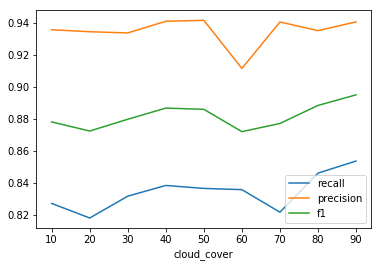

In [187]:
# Visualize training metrics

metrics.plot(x='cloud_cover', y=['recall', 'precision','f1'])

### Predict on cloud gaps

In [188]:
def preprocessing_gaps(path, img, pctl):

    # Get local image
    with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
        data = ds.read()
        data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)
    
    # load cloudmasks
    cloudMaskDir = path+'cloudmasks/'+img
    
    cloudMask = np.load(cloudMaskDir+'/'+img+'_clouds_'+str(pctl)+'.npy')
    
    # Invert cloudmask to get the gaps
    cloudMask = np.invert(cloudMask)
    
    # Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN
    data[cloudMask] = -999999
    
    # Convert -999999 to None
    data[data == -999999] = np.nan

    # Get indices of non-nan values. These are the indices of the original image array
    data_ind = np.where(~np.isnan(data[:,:,1]))
    
    # Reshape into a single vector of pixels.
    data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

    # Remove NaNs
    data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]

    # Compute per-band means and standard deviations of the input bands.
    data_mean = training_data[:,0:14].mean(0)
    data_std = training_data[:,0:14].std(0)

    return data_vector, data_mean, data_std

Problem: TF doesn't save every variable, like outputs or input, so we need to save those somehow
https://stackoverflow.com/questions/43887425/how-to-import-a-model-in-tensorflow

In [214]:
def gapFill(data_vector, data_mean, data_std, img, pctl):
    
    model_name = img+'_clouds_'+str(pctl)
    
    NUM_INPUT_BANDS = 14
    NUM_HIDDEN_1 = 15
    NUM_HIDDEN_2 = 15
    NUM_CLASSES = 2

    # Prepare feed dictionary

    input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
    labels = tf.placeholder(tf.float32, shape=[None])

    normalized = (input - data_mean) / data_std
    
    hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1))
    hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2))
    logits = make_nn_layer(hidden2, NUM_CLASSES)
    outputs = tf.argmax(logits, 1)

    int_labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # should we minimize something else?

    correct_prediction = tf.equal(outputs, int_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Had to alter some config and runoptions because kept running into OOM at last step during eval 
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    # run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)


    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer(), options=run_options)
        mySaver = tf.train.import_meta_graph(model_path+model_name+'.ckpt-1000.meta')
        mySaver.restore(sess, tf.train.latest_checkpoint(model_path+'./'))

        y_pred = outputs.eval({input: data_vector[:,0:14]})
    
    return y_pred


In [216]:
y_pred = gapFill(data_vector, data_mean, img, 80)
y_pred

INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_90.ckpt-1000


array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [220]:
pctl=80
model_name = img+'_clouds_'+str(pctl)
model_path+model_name+'.ckpt-1000.meta'

'C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_80.ckpt-1000.meta'

In [199]:
model_path = path+'models/cnn_vary_clouds/'
pctls = [10,20,30,40,50,60,70,80,90]
img = '4337_LC08_026038_20160325_1'

precision = []
recall = []
f1 = []
accuracy = []
predictions = []

for i, pctl in enumerate(pctls):
    
    data_vector, data_mean, data_std = preprocessing_gaps(path, img, pctl)
    
    y_pred = gapFill(data_vector, data_mean, data_std, img, pctl)
    
    y_true = data_vector[:,14]
    
    precision.append(sklearn.metrics.precision_score(y_true, y_pred))
    recall.append(sklearn.metrics.recall_score(y_true, y_pred))
    f1.append(sklearn.metrics.f1_score(y_true, y_pred))
    predictions.append(y_pred)

INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_90.ckpt-1000


NameError: name 'outputs' is not defined